# Anagen evaluation

In [3]:
# setup
import pandas as pd
import nltk
from tqdm import tqdm
from transformers import GPT2Tokenizer
from nltk.parse import CoreNLPParser
from nltk.translate.bleu_score import corpus_bleu

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

raw_res_file = "results/b28_res.csv"
model_dir = "/home/hansonlu/links/data/anagen_models/anagen_b28_model"

tokenizer = GPT2Tokenizer.from_pretrained(model_dir)

# for parser
# in terminal, run the following script:
"""
cd ~/stanford-corenlp-full-2018-02-27
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer \
> -preload tokenize,ssplit,pos,lemma,ner,parse,depparse \
> -status_port 9000 -port 9000 -timeout 15000 & 
"""

# parser = CoreNLPParser(url='http://localhost:9000')

# for named entity recoginition

import spacy
nlp = spacy.load("en_core_web_sm")

NUM_SAMPLES=5



OSError: Model name '/home/hansonlu/links/data/anagen_models/anagen_b28_model' was not found in tokenizers model name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). We assumed '/home/hansonlu/links/data/anagen_models/anagen_b28_model' was a path or url to a directory containing vocabulary files named ['vocab.json', 'merges.txt'] but couldn't find such vocabulary files at this path or url.

In [8]:
raw_df = pd.read_csv(raw_res_file)

In [9]:
from nltk.tokenize import word_tokenize
def tokenize(text, use_gpt2=False):
    if use_gpt2:
        return [t.lstrip("Ġ") for t in tokenizer.tokenize(text)]
    else:
        return word_tokenize(text)

## BLEU score

In [10]:
def evaluate_BLEU(df):
    references = []
    preds = []
    for i, row in df.iterrows():
        # retokenize both strings using GPT2 Tokenizer
        gold_toks = [tokenize(row["gold"], use_gpt2=True)]
        pred_toks = tokenize(row["pred0"], use_gpt2=True)
        references.append(gold_toks)
        preds.append(pred_toks)
    score = corpus_bleu(references, preds)
    return score
    

In [11]:
BLEU_score = evaluate_BLEU(raw_df)
BLEU_score

0.046143494367558144

## Categorizing each output

In [12]:
# nltk.download()

In [13]:
import nltk
text = tokenize("that")
nltk.pos_tag(text)[0][1]

'IN'

In [14]:
def look_for_poss_pron(df):
    pron_list = ["both", "few", "many","several"]
#                 "herself", "itself", "themselves"]
    count = 0
    for i, row in df.iterrows():
        g = tokenize(row["gold"])
        if len(g) == 1 and g[0] in pron_list:
            print(row["context"] + " >>>(gold)>>> " + g[0])
            count += 1
        for j in range(NUM_SAMPLES):
            s = tokenize(row["pred%d"%j])
            if len(s) > 1:
                continue
            if s[0] in pron_list:
                print(row["context"] + " >>>(pred)>>> " + s[0])
                count += 1
    print(count)

In [15]:
# look_for_poss_pron(raw_df)

They announced a reduction in formalities for travel , but did n't show any real signs of resuming full diplomatic ties . The Egyptian president said he would visit Libya today to resume the talks . <anteced> Seoul and Pyongyang </anteced> reached a tentative agreement to allow visits between families on the divided Korean peninsula . Such family reunions would be the second since 1945 . Differences remained between >>>(pred)>>> both
In an interview Thursday , Claude Bebear , <anteced> chairman and chief executive officer </anteced> of Axa , said his group has already obtained assurances from a group of banks led by Cie . Financiere de Paribas that they can provide the loan portion of the financing . The other banking companies in the group are Credit Lyonnais , Societe Generale , BankAmerica Corp. and Citicorp , >>>(pred)>>> both
In an interview Thursday , Claude Bebear , chairman and chief executive officer of Axa , said <anteced> his </anteced> group has already obtained assurances 

In [16]:
personal_pron_list = ["I", "me", "my", "mine", 
                        "you", "your", "yours",
                        "she", "her", "hers",
                        "he", "him", "his",
                        "it", "its",
                        "we", "us", "our", "ours",
                        "they", "them", "their", "theirs",
                      "myself", "ourselves",
                      "yourself", "yourselves",
                      "himself", "herself", "itself",
                     "theirselves", "theirself"]
other_pron_list = ["this", "these",
                "that", "those",
                "all", "any", "most", "some", "none",
                "anybody", "anyone", "anything","each",
                "either","everybody","everyone","everything","neither","nobody",
                "one","someone","somebody","something",
                "both","few","many","several"]
personal_pron_set = set(personal_pron_list)
other_pron_set = set(other_pron_list)

def is_pronoun(toks):
    # assume all pronouns have length==1
    if len(toks) > 1:
        return False
    s = toks[0]
    if s != "I":
        s = s.lower()
    return (s in personal_pron_set or s in other_pron_set)
    

In [17]:
def is_named_entity(text):
    """uses spaCy to determine if a text is an entity"""
    text = text.strip("'s")
    doc = nlp(text)
    if len(doc.ents) != 1:
        return False
    ent = doc.ents[0]
    return ent.start_char == 0 and ent.end_char == len(text)
    

In [18]:
def get_type(s):
    toks = tokenize(s)
    if "<anaphor>" in s:
        return "invalid"
    if is_pronoun(toks):
        return "pronoun" # pronoun
    if is_named_entity(s):
        return "name"
    else:
        return "other"

In [19]:
raw_df.head()

,context,gold,pred0,pred1,pred2,pred3,pred4
0,"With <anteced> their </anteced> unique charm ,",these well - known cartoon images,they,the two men's,they,the girls,they
1,"With their unique charm , these well - known c...",Disney,the park,that park,that,this,the new park
2,"With their unique charm , these well - known c...",it,it,it,it,they,it
3,"With their unique charm , these well - known c...",it,it,the park,it,it,they
4,"With their unique charm , these well - known c...",it,Hong Kong,its,the parks,it,its


In [20]:
def add_column(df, pos, column_name, default=None):
    if column_name not in df.columns:
        df.insert(pos, column_name, default)

def categorize(df):
    # update df to include categories of predictions
    
    # add new category columns to dataframe, if not exists
    add_column(df, len(df.columns), "gold_type")
    for j in range(NUM_SAMPLES):
        new_col_pos = add_column(df, len(df.columns), "pred%d_type" % j)
        
    # initialize update_dict
    update_dict = {"gold_type": []}
    for j in range(NUM_SAMPLES):
        update_dict["pred%d_type" % j] = []
        
    # find categories
    total_rows = df.shape[0]
    for i, row in tqdm(df.iterrows(),total=total_rows):
        update_dict["gold_type"].append(get_type(row["gold"]))
        for j in range(NUM_SAMPLES):
            update_dict["pred%d_type" % j].append(get_type(row["pred%d" % j]))
    
    df.update(pd.DataFrame(update_dict))
        

In [21]:
categorize(raw_df)

100%|██████████| 7995/7995 [01:08<00:00, 117.30it/s]


In [68]:
raw_df.head()

,context,gold,pred0,pred1,pred2,pred3,pred4,gold_type,pred0_type,pred1_type,pred2_type,pred3_type,pred4_type
0,"With <anteced> their </anteced> unique charm ,",these well - known cartoon images,they,the two men's,they,the girls,they,other,pronoun,other,pronoun,other,pronoun
1,"With their unique charm , these well - known c...",Disney,the park,that park,that,this,the new park,other,other,other,pronoun,pronoun,other
2,"With their unique charm , these well - known c...",it,it,it,it,they,it,pronoun,pronoun,pronoun,pronoun,pronoun,pronoun
3,"With their unique charm , these well - known c...",it,it,the park,it,it,they,pronoun,pronoun,other,pronoun,pronoun,pronoun
4,"With their unique charm , these well - known c...",it,Hong Kong,its,the parks,it,its,pronoun,name,pronoun,other,pronoun,pronoun


## Todo

- Calculate BLEU scores for names and other

- Calculate accuracy, precision and recall for pronouns

- Generate confusion matrix plot

- Gender and number agreement

## BLEU score for names and other

In [76]:
def evaluate_BLEU_for_non_pronouns(df):
    references = []
    preds = []
    for i, row in df.iterrows():
        # retokenize both strings using GPT2 Tokenizer
        if row["gold_type"] == "other" and row["pred0_type"] == "other":
            gold_toks = [tokenize(row["gold"], use_gpt2=True)]
            pred_toks = tokenize(row["pred0"], use_gpt2=True)
            references.append(gold_toks)
            preds.append(pred_toks)
    score = corpus_bleu(references, preds)
    return score

In [77]:
evaluate_BLEU_for_non_pronouns(raw_df)

0.1306181519023153

## Confusion matrix analysis for categories

In [80]:
def category_confusion_mtx_analysis(df, pred_i=0):
    assert pred_i < NUM_SAMPLES
    
    total_count = 0
    invalid_count = 0
    golds = []
    preds = []
    
    for i, row in df.iterrows():
        total_count += 1
        if row["pred%d_type" % pred_i] == "invalid":
            invalid_count += 1
        golds.append(row["gold_type"])
        preds.append(row["pred%d_type" % pred_i])
    
    labels = ["pronoun", "name", "other", "invalid"]
    cmtx = confusion_matrix(golds, preds, labels=labels)
    df_cm = pd.DataFrame(cmtx, index=labels, columns=labels)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, fmt="d", annot=True,annot_kws={"size": 18})# font size

    plt.show()
    return cmtx
    

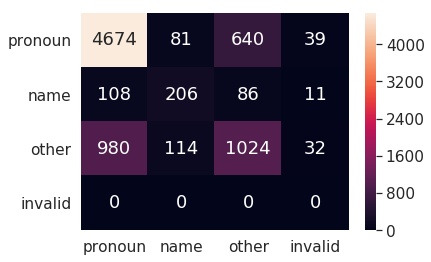

In [81]:
cmtx = category_confusion_mtx_analysis(raw_df, 0)

## Category analysis

In [82]:
from collections import Counter

def mulit_sample_category_confusion_mtx_analysis(df):    
    golds = []
    preds = []
    
    for i, row in df.iterrows():
        golds.append(row["gold_type"])
        curr_preds = Counter()
        match = False
        for j in range(NUM_SAMPLES):
            curr_preds[row["pred%d_type" % j]] += 1
            if row["pred%d_type" % j] == row["gold_type"]:
                preds.append(row["pred%d_type" % j])
                match = True
                break
        if not match:
            preds.append(curr_preds.most_common(1)[0][0])
                
    labels = ["pronoun", "name", "other", "invalid"]
    cmtx = confusion_matrix(golds, preds, labels=labels)
    df_cm = pd.DataFrame(cmtx, index=labels, columns=labels)
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, fmt="d", annot=True,annot_kws={"size": 18})# font size

    plt.show()
    return cmtx

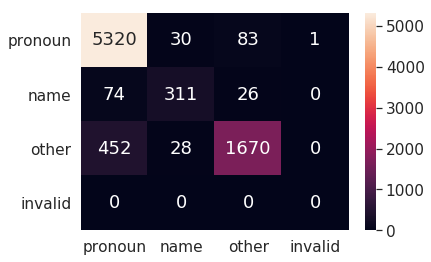

In [83]:
cmtx = mulit_sample_category_confusion_mtx_analysis(raw_df)

## Pronoun confusion matrix analysis

In [86]:
def pronoun_confusion_mtx_analysis(df, pred_i=0):
    assert pred_i < NUM_SAMPLES

    golds = []
    preds = []
    
    for i, row in df.iterrows():
        if row["gold_type"] == "pronoun" and row["pred%d_type"% pred_i] == "pronoun":
            golds.append(row["gold"])
            preds.append(row["pred%d" % pred_i])
    
    labels = ["I", "me", "my", "mine", 
                        "you", "your", "yours",
                        "she", "her",
                        "he", "him", "his",
                        "it", "its",
                        "we", "us", "our", "ours",
                        "they", "them", "their"]
    cmtx = confusion_matrix(golds, preds, labels=labels)
    df_cm = pd.DataFrame(cmtx, index=labels, columns=labels)
    plt.figure(figsize = (12,6))
    sns.set(font_scale=1)#for label size
    sns.heatmap(df_cm, fmt="d", annot=True,annot_kws={"size": 10})# font size

    plt.show()
    return cmtx

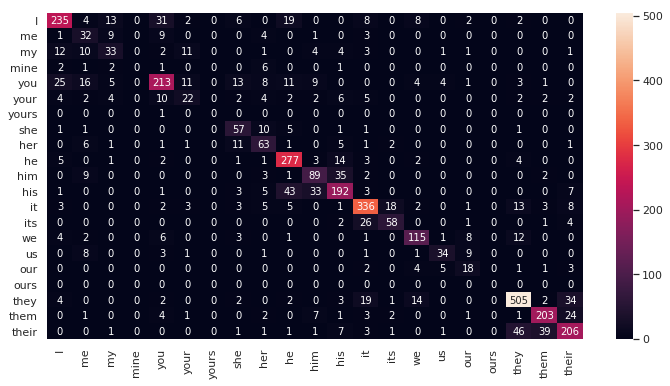

In [87]:
cmtx = pronoun_confusion_mtx_analysis(raw_df)

## accuracy, precision, recall for pronouns

In [ ]:
def evaluate_pron_acc_prec_rec(df):
    

In [ ]:
# example of how to use parser

# in terminal, run the following script:
"""
cd ~/stanford-corenlp-full-2018-02-27
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer \
> -preload tokenize,ssplit,pos,lemma,ner,parse,depparse \
> -status_port 9000 -port 9000 -timeout 15000 & 
"""

from nltk.parse import CoreNLPParser
parser = CoreNLPParser(url='http://localhost:9000')

list(parser.raw_parse("I put the book in the box on the table."))
